## Image网 Submission `128x128`

This contains a submission for the Image网 leaderboard in the `128x128` category.

In this notebook we:
1. Train on 1 pretext task: 
  - Train a network to do image inpatining on Image网's `/train`, `/unsup` and `/val` images. 
2. Train on 4 downstream tasks:
  - We load the pretext weights and train for `5` epochs.
  - We load the pretext weights and train for `20` epochs.
  - We load the pretext weights and train for `80` epochs.
  - We load the pretext weights and train for `200` epochs.
  
Our leaderboard submissions are the accuracies we get on each of the downstream tasks.

In [1]:
import json
import torch

import numpy as np

from functools import partial

from fastai2.layers import Mish, MaxPool, LabelSmoothingCrossEntropy
from fastai2.learner import Learner
from fastai2.metrics import accuracy, top_k_accuracy
from fastai2.basics import DataBlock, RandomSplitter, GrandparentSplitter, CategoryBlock

from fastai2.optimizer import ranger, Adam, SGD, RMSProp

from fastai2.vision.all import *
from fastai2.vision.core import *
from fastai2.vision.augment import *
from fastai2.vision.learner import unet_learner, unet_config
from fastai2.vision.models.xresnet import xresnet50, xresnet34

from fastai2.data.transforms import Normalize, parent_label
from fastai2.data.external import download_url, URLs, untar_data


from fastcore.utils import num_cpus

from torch.nn import MSELoss
from torchvision.models import resnet34

In [2]:
torch.cuda.set_device(1)

## Pretext Task: Image Inpainting

In [3]:
# Chosen parameters
lr=8e-3
sqrmom=0.99
mom=0.95
beta=0.
eps=1e-4
bs=64 
opt='ranger'
sa=1
fp16=1
pool='MaxPool'
sym=0

# NOTE: Normally loaded from their corresponding string
m = xresnet34
act_fn = Mish
pool = MaxPool

nc=20

In [4]:
source = untar_data(URLs.IMAGEWANG_160)
len(get_image_files(source/'unsup')), len(get_image_files(source/'train'))

(7750, 14669)

In [5]:
# [s.name for s in (source/'train').ls()], [s.name for s in (source/'val').ls()]

In [6]:
def get_dbunch(size, bs, workers=8):
    path = URLs.IMAGEWANG_160 if size <= 160 else URLs.IMAGEWANG
    source = untar_data(path)
    
    files = get_image_files(source)
    
    tfms = [[PILImage.create, ToTensor, Resize(size)], 
            [lambda x: x.parent.name, Categorize()]]
    
    dsets = Datasets(files, tfms=tfms, splits=RandomSplitter(valid_pct=0.1)(files))
    
    batch_tfms = [IntToFloatTensor, Normalize.from_stats(*imagenet_stats)]
    dls = dsets.dataloaders(bs=bs, num_workers=workers, after_batch=batch_tfms)
    dls.path = source
    return dls

In [7]:
# Use the Ranger optimizer
opt_func = partial(ranger, mom=mom, sqr_mom=sqrmom, eps=eps, beta=beta)

In [8]:
size = 128
bs = 256

dbunch = get_dbunch(160, bs)
dbunch.c = nc

In [9]:
len(dbunch.train.dataset)

23714

In [10]:
xb,yb = dbunch.one_batch()
xb.shape, yb.shape

(torch.Size([256, 3, 160, 160]), torch.Size([256]))

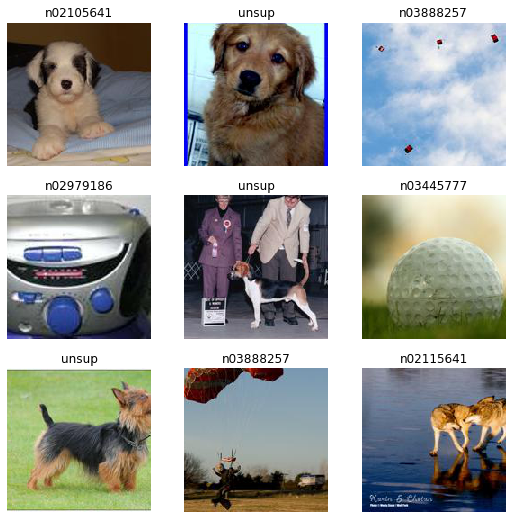

In [11]:
dbunch.show_batch()

In [12]:

from rsna_retro.self_supervised import *
from rsna_retro.contrastive_loss import *

Loading imports


In [ ]:
#export
def get_aug_pipe(size, min_scale=0.4, stats=(mean,std), **kwargs):
    tfms = [Normalize.from_stats(*stats)] + aug_transforms(size=size, min_scale=min_scale, **kwargs)
    return Pipeline(tfms)

In [13]:
m_part = partial(m, c_out=nc, act_cls=torch.nn.ReLU, sa=sa, sym=sym, pool=pool)

In [14]:
ss_name = 'imagewang_contrast_ss4'

In [15]:
aug = get_aug_pipe(size, min_scale=0.20, mult=1, stats=imagenet_stats)
aug2 = get_aug_pipe(size, min_scale=0.15, mult=2, stats=imagenet_stats)
cbs = SSCallback(XentLoss(0.1), size=size, aug_targ=aug, aug_pos=aug2, multi_loss=False)
# cbs = SSCallback(BatchContrastiveLoss(XentLoss(0.1)), size=size, aug_targ=aug, aug_pos=aug2, multi_loss=False)


# ch = nn.Sequential(nn.AdaptiveAvgPool2d(1), Flatten(), nn.Linear(512, 128))
ch = nn.Sequential(nn.AdaptiveAvgPool2d(1), Flatten(), nn.Linear(512, 256), nn.ReLU(), nn.Linear(256, 64))
learn = cnn_learner(dbunch, m_part, opt_func=opt_func,
                    metrics=[], loss_func=CrossEntropyLossFlat(), cbs=cbs,
                    config={'custom_head':ch}, pretrained=False,
                   )
#         metrics=[], loss_func=LabelSmoothingCrossEntropy())

In [16]:
learn.unfreeze()
learn.fit_flat_cos(30, 1e-2, wd=1e-3)

epoch,train_loss,valid_loss,time
0,1.116473,0.818081,00:49
1,0.756609,0.670071,00:47
2,0.583279,0.420965,00:47
3,0.502308,0.843531,00:47
4,0.558716,0.702817,00:47
5,0.519977,0.609973,00:47
6,0.397056,0.846489,00:48
7,0.389407,0.568214,00:47
8,0.385723,0.547918,00:47
9,0.353184,0.639546,00:47


In [17]:
learn.save(f'{ss_name}')

In [16]:
learn.load(f'{ss_name}')

In [17]:
learn.unfreeze()
learn.fit_flat_cos(30, 4e-3, wd=1e-3)

epoch,train_loss,valid_loss,time
0,0.266333,0.519503,00:49
1,0.270989,0.491697,00:46
2,0.268213,0.537878,00:47
3,0.259928,0.425924,00:47
4,0.248736,0.507294,00:47
5,0.291388,0.393643,00:47
6,0.254023,0.540489,00:47
7,0.269596,0.651160,00:47
8,0.310922,0.438818,00:47
9,0.261334,0.655293,00:47


In [18]:
learn.save(f'{ss_name}-1')

## Downstream Task: Image Classification

In [16]:
def get_dbunch(size, bs, workers=8):
    path = URLs.IMAGEWANG_160 if size <= 160 else URLs.IMAGEWANG
    source = untar_data(path)
    
    files = get_image_files(source)
    
    item_aug = [RandomResizedCrop(size, min_scale=0.35), FlipItem(0.5)]
    tfms = [[PILImage.create, ToTensor, *item_aug], 
            [lambda x: x.parent.name, Categorize()]]
    
    dsets = Datasets(files, tfms=tfms, splits=GrandparentSplitter(valid_name='val')(files))
    
    batch_tfms = [IntToFloatTensor, Normalize.from_stats(*imagenet_stats)]
    dls = dsets.dataloaders(bs=bs, num_workers=workers, after_batch=batch_tfms)
    dls.path = source
    return dls

In [17]:
size=128
bs = 64
dbunch = get_dbunch(size, bs)

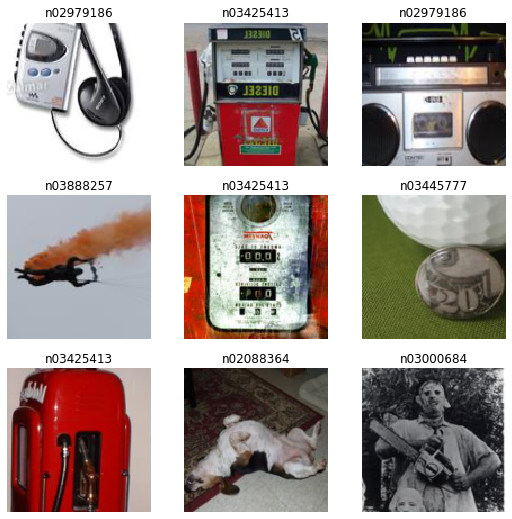

In [18]:
dbunch.show_batch()

### 5 Epochs

In [19]:
epochs = 5
runs = 1

In [20]:
for run in range(runs):
        print(f'Run: {run}')
        
#         aug = get_aug_pipe(size, min_scale=1.0, mult=1)
#         aug2 = get_aug_pipe(size, min_scale=0.3, mult=1)
#         cbs = SSCallback(BatchContrastiveLoss(XentContrastiveLoss(0.05)), size=size, aug_targ=aug, aug_pos=aug2, multi_loss=True)

        ch = nn.Sequential(nn.AdaptiveAvgPool2d(1), Flatten(), nn.Linear(512, 256))
        learn = cnn_learner(dbunch, m_part, opt_func=opt_func,
                metrics=[accuracy,top_k_accuracy], loss_func=CrossEntropyLossFlat(),
                pretrained=False,
                config={'custom_head':ch})#, cbs=cbs)
        
#         if fp16: learn = learn.to_fp16()
        learn.load(f'{ss_name}-1', strict=False)
        learn.model[1][-1] = nn.Linear(512, 20)
        
        learn.unfreeze()
#         learn.freeze()
#         learn.lr_find()
        learn.fit_flat_cos(epochs, 1e-2, wd=1e-3)

Run: 0


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,time
0,1.299700,3.248835,0.055994,0.495546,00:21
1,1.016702,2.852968,0.141766,0.597098,00:20
2,0.887090,2.922541,0.141003,0.747518,00:20
3,0.799517,2.454050,0.256808,0.757699,00:20
4,0.605313,2.078957,0.357597,0.815475,00:21


In [21]:
for run in range(runs):
        print(f'Run: {run}')
        
        aug = get_aug_pipe(size, min_scale=0.35, mult=1)
        aug2 = get_aug_pipe(size, min_scale=0.3, mult=1)
        cbs = SSCallback(XentLoss(0.1), size=size, aug_targ=aug, aug_pos=aug2, multi_loss=True)

        ch = nn.Sequential(nn.AdaptiveAvgPool2d(1), Flatten(), nn.Linear(512, 256))
        learn = cnn_learner(dbunch, m_part, opt_func=opt_func,
                metrics=[accuracy,top_k_accuracy], loss_func=CrossEntropyLossFlat(),
                pretrained=True,
                config={'custom_head':ch}, cbs=cbs)
        
#         if fp16: learn = learn.to_fp16()
#         learn.load(f'{ss_name}-1', strict=False)
        learn.model[1][-1] = nn.Linear(512, 20)
        
        learn.unfreeze()
#         learn.freeze()
#         learn.lr_find()
        learn.fit_flat_cos(epochs, 2e-2, wd=1e-2)

Run: 0


epoch,train_loss,valid_loss,accuracy,top_k_accuracy,ss_loss,orig_loss,time
0,2.481632,7.743039,0.013744,0.276661,3.601335,4.141705,00:37
1,2.144902,6.511646,0.043777,0.336981,2.680042,3.831605,00:37
2,1.935702,6.208614,0.048613,0.381522,2.505115,3.703500,00:37
3,1.749550,6.598837,0.059812,0.400611,2.847038,3.751799,00:38
4,1.511815,5.852283,0.083991,0.460932,2.297385,3.554899,00:37


In [27]:
len(learn.opt.opt.param_groups)

2

- Run 1: 0.403156
- Run 2: 0.404429
- Run 3: 0.416645
- Run 4: 0.407228
- Run 5: 0.412064

Average: **40.87%**

### 20 Epochs

In [ ]:
epochs = 20
runs = 3

In [ ]:
for run in range(runs):
        print(f'Run: {run}')
        ch = nn.Sequential(nn.AdaptiveAvgPool2d(1), Flatten(), nn.Linear(512, 20))
        learn = cnn_learner(dbunch, m_part, opt_func=opt_func,
                metrics=[accuracy,top_k_accuracy], loss_func=CrossEntropyLossFlat(),
                config={'custom_head':ch})#, cbs=cbs)
        
        if dump: print(learn.model); exit()
#         if fp16: learn = learn.to_fp16()
        cbs = MixUp(mixup) if mixup else []
        learn.load(ss_name, strict=True)
        
        learn.freeze()
        learn.fit_flat_cos(epochs, lr, wd=1e-2, cbs=cbs)

- Run 1: 0.610333
- Run 2: 0.618733
- Run 3: 0.605498

Average: **61.15%**

## 80 epochs

In [ ]:
epochs = 80
runs = 1

In [ ]:
for run in range(runs):
        print(f'Run: {run}')
        ch = nn.Sequential(nn.AdaptiveAvgPool2d(1), Flatten(), nn.Linear(512, 20))
        learn = cnn_learner(dbunch, m_part, opt_func=opt_func,
                metrics=[accuracy,top_k_accuracy], loss_func=CrossEntropyLossFlat(),
                config={'custom_head':ch})#, cbs=cbs)
        
        if dump: print(learn.model); exit()
#         if fp16: learn = learn.to_fp16()
        cbs = MixUp(mixup) if mixup else []
        learn.load(ss_name, strict=True)
        
        learn.freeze()
        learn.fit_flat_cos(epochs, lr, wd=1e-2, cbs=cbs)

Accuracy: **62.18%**

### 200 epochs

In [ ]:
epochs = 200
runs = 1

In [ ]:
for run in range(runs):
        print(f'Run: {run}')
        ch = nn.Sequential(nn.AdaptiveAvgPool2d(1), Flatten(), nn.Linear(512, 20))
        learn = cnn_learner(dbunch, m_part, opt_func=opt_func,
                metrics=[accuracy,top_k_accuracy], loss_func=CrossEntropyLossFlat(),
                config={'custom_head':ch})#, cbs=cbs)
        
        if dump: print(learn.model); exit()
#         if fp16: learn = learn.to_fp16()
        cbs = MixUp(mixup) if mixup else []
        learn.load(ss_name, strict=True)
        
        learn.freeze()
        learn.fit_flat_cos(epochs, lr, wd=1e-2, cbs=cbs)

Accuracy: **62.03%**